In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [3]:
sys.path.append('..')

In [4]:
def coverage_age(p,e):
    return (1 +((1-e)*((1/p) -1)))**-1

In [21]:
def error_coverage_age(p,e):
    var = (1-e)/((e*(p-1) + 1)**2)
    return np.sqrt(var)

# Calculating $S_0$: first method

- Using ignored data as vaccinated
- Using stratified population, grouping since it is our only option now

We will do this by:
- Calculating $P(V_i|S_i)$ with its error
- Propagating to get $c_i$ with its error
- Propagating to get $S_0$ with its error

## Example for Sao Paulo

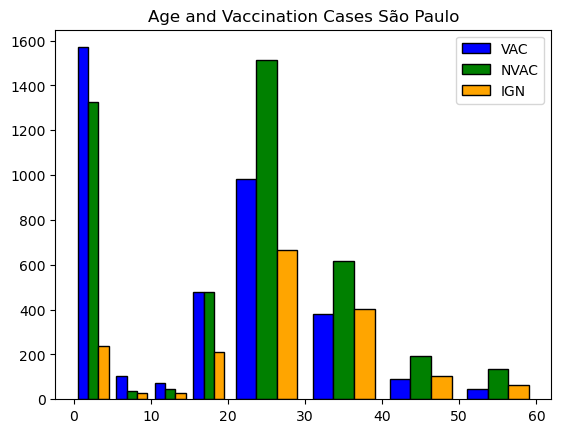

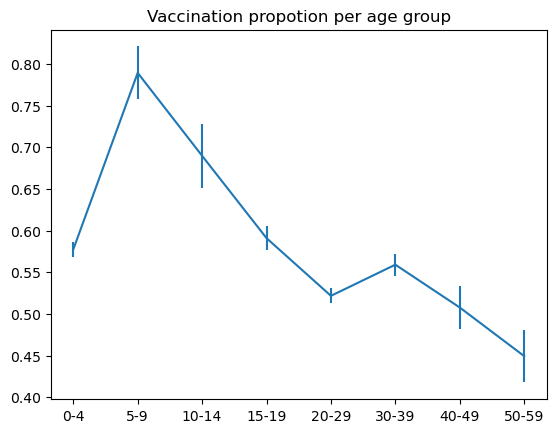

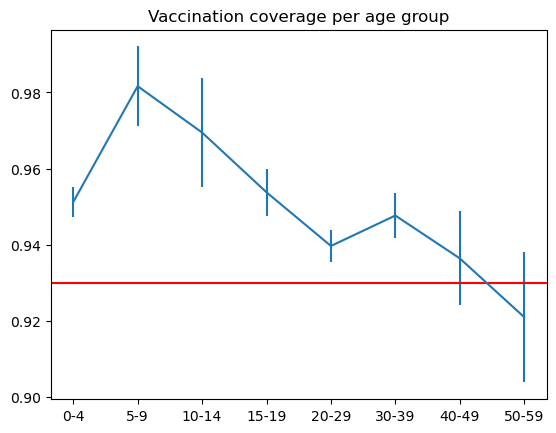

564065.9431631977 39772.754960687045


In [52]:
first_10 = [355030.]
first_10_names = ['SP']

# data for municipalities by age
data_muns = pd.read_csv('../Data/age_groups_municipalities.csv')


# data of cases, age and their vaccination status
df_mun = pd.read_csv('../Data/analyzed/age_vaccine_municipalities.csv')
mun_path = '../Data/municipalities.csv'
mun_file = pd.read_csv(mun_path)
mun_file['codigo'] = mun_file['municipio'].astype(str).str[:6].astype(int)
mun_file = mun_file[['municipio','name','codigo']]
df_mun = df_mun.merge(mun_file, how = 'left', left_on = 'ID_MN_RESI', right_on = 'codigo')



for mun in first_10:
    df_tmp = df_mun[df_mun['ID_MN_RESI'] == mun]
    df_tmp = df_tmp[df_tmp['NU_IDADE_N'] <= 60]
    mun_name = df_tmp['name'].unique()[0]
    min_age = 0
    max_age = 60
    colors=['blue', 'green', 'orange']
    names=['VAC', 'NVAC', 'IGN']
    x_vac = list(df_tmp[df_tmp['CS_VACINA'] == 1]['NU_IDADE_N'])
    x_nvac = list(df_tmp[df_tmp['CS_VACINA'] == 2]['NU_IDADE_N'])
    x_ign = list(df_tmp[df_tmp['CS_VACINA'] == 9]['NU_IDADE_N'])
    bins_grouped = np.array([0,5,10,15,20,30,40,50,60])
    #bins_grouped = np.array([0,5,10,15,20,30,40])
    bins = plt.hist([x_vac, x_nvac, x_ign], color=colors, label=names, bins=bins_grouped,  edgecolor = 'black')
    plt.title('Age and Vaccination Cases '+ str(mun_name))
    plt.legend()
    plt.show()
    vacs = bins[0][0]
    nvacs = bins[0][1]
    ign = bins[0][2]
    vacs = vacs + ign
    # first we calculate the proportion of vaccinated
    N = vacs+nvacs # sample size
    p_vacs = vacs/N # proportion of sample
    # now we calculate errors for these proportions 
    e_p_vacs = np.sqrt(p_vacs*(1 - p_vacs)/N)
    # plotting the proportion with its error
    fig, ax = plt.subplots()
    ax.errorbar(np.arange(len(p_vacs)),p_vacs, yerr = e_p_vacs)
    ax.set_xticks(np.arange(len(p_vacs)))
    ax.set_xticklabels(['0-4','5-9','10-14','15-19', '20-29', '30-39','40-49','50-59'])
    ax.set_title('Vaccination propotion per age group')
    # second we propagate to calculate the vaccination coverage
    eps = 0.93 # vaccine efficacy
    c_vacs = coverage_age(p_vacs,eps)
    e_c_vacs = error_coverage_age(p_vacs,eps)*e_p_vacs
    fig, ax = plt.subplots()
    ax.errorbar(np.arange(len(c_vacs)),c_vacs, yerr = e_c_vacs)
    ax.set_xticks(np.arange(len(c_vacs)))
    ax.set_xticklabels(['0-4','5-9','10-14','15-19', '20-29', '30-39','40-49','50-59'])
    ax.set_title('Vaccination coverage per age group')
    ax.axhline(0.93,color = 'r')
    plt.show()
    # third we calculate S0 with its corresponding error
    data_sp = data_muns[data_muns['Municipio'] == mun]
    data_sp = data_sp.to_numpy()[0]
    data_sp = data_sp[2:10]
    gap_vacs = 1 - np.array(c_vacs)
    S0 = np.sum(data_sp*gap_vacs)
    e_S0 = np.sqrt(np.sum((data_sp*e_c_vacs)**2))
    print(S0,e_S0)